In [1]:
import os
import obspy 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution1D, Dropout, MaxPool1D
from keras.optimizers import Adam 

In [3]:
# Reading seismograms
indir1 = './wavedata/N' # <- N-S component seismograms
indir2 = './wavedata/E' # <- E-W component seismograms

st_n_raw = obspy.Stream()
st_e_raw = obspy.Stream()
st_n = obspy.Stream()
st_e = obspy.Stream()
list_sacfile_path1 = []
list_sacfile_path2 = []
evtnum = len(os.listdir(indir1))
list_sacfile1 = os.listdir(indir1)
list_sacfile2 = os.listdir(indir2)

for i_sacfile in list_sacfile1:
    list_sacfile_path1.append( os.path.join(indir1, i_sacfile) )
for i_sacfile in list_sacfile2:
    list_sacfile_path2.append( os.path.join(indir2, i_sacfile) )

# N-S component seismogram
st_n_raw = obspy.read(list_sacfile_path1[0])
for i in range(1,evtnum):
    st_n_raw += obspy.read(list_sacfile_path1[i])
# E-W component seismogram
st_e_raw = obspy.read(list_sacfile_path2[0])
for i in range(1,evtnum):
    st_e_raw += obspy.read(list_sacfile_path2[i])

# Filtering
st_n = st_n_raw.filter('bandpass', freqmin=4.0, freqmax=32.0, corners=2, zerophase=True)
st_e = st_e_raw.filter('bandpass', freqmin=4.0, freqmax=32.0, corners=2, zerophase=True)

# Amplitude normalization & Cut-out S coda 
p_pick = np.zeros([evtnum,1])
s_pick = np.zeros([evtnum,1])
s_coda_n = np.zeros([evtnum,1024])
s_coda_e = np.zeros([evtnum,1024])
sampling_freq = st_n[0].stats.sampling_rate

for i in range(0,evtnum):
    
    s_pick_n  = st_n[i].stats.sac.t1 - st_n[i].stats.sac.b
    s_pick_e  = st_e[i].stats.sac.t1 - st_e[i].stats.sac.b

    idx1_n = int(s_pick_n* int(sampling_freq)) - 20
    idx2_n = int((s_pick_n + 10.24)*int(sampling_freq)) - 20
    idx1_e = int(s_pick_e*int(sampling_freq)) - 20
    idx2_e = int((s_pick_e + 10.24)*int(sampling_freq)) - 20

    idx1max_n = int((s_pick_n - 1.0)*int(sampling_freq))
    idx2max_n = int((s_pick_n + 1.0)*int(sampling_freq))
    idx1max_e = int((s_pick_e - 1.0)*int(sampling_freq))
    idx2max_e = int((s_pick_e + 1.0)*int(sampling_freq))

    maxamp_n = np.max(np.abs(st_n[i].data[idx1max_n:idx2max_n]))
    maxamp_e = np.max(np.abs(st_e[i].data[idx1max_e:idx2max_e]))

    s_coda_n[i] = (st_n[i].data / maxamp_n).data[idx1_n:idx2_n]
    s_coda_e[i] = (st_e[i].data / maxamp_e).data[idx1_e:idx2_e]

# Input data
x_pred = np.zeros([1024,2])
x_pred = np.stack([s_coda_n, s_coda_e])
x_pred = x_pred.transpose(1, 2, 0)

Text(0, 0.5, 'Normarized Amplitude')

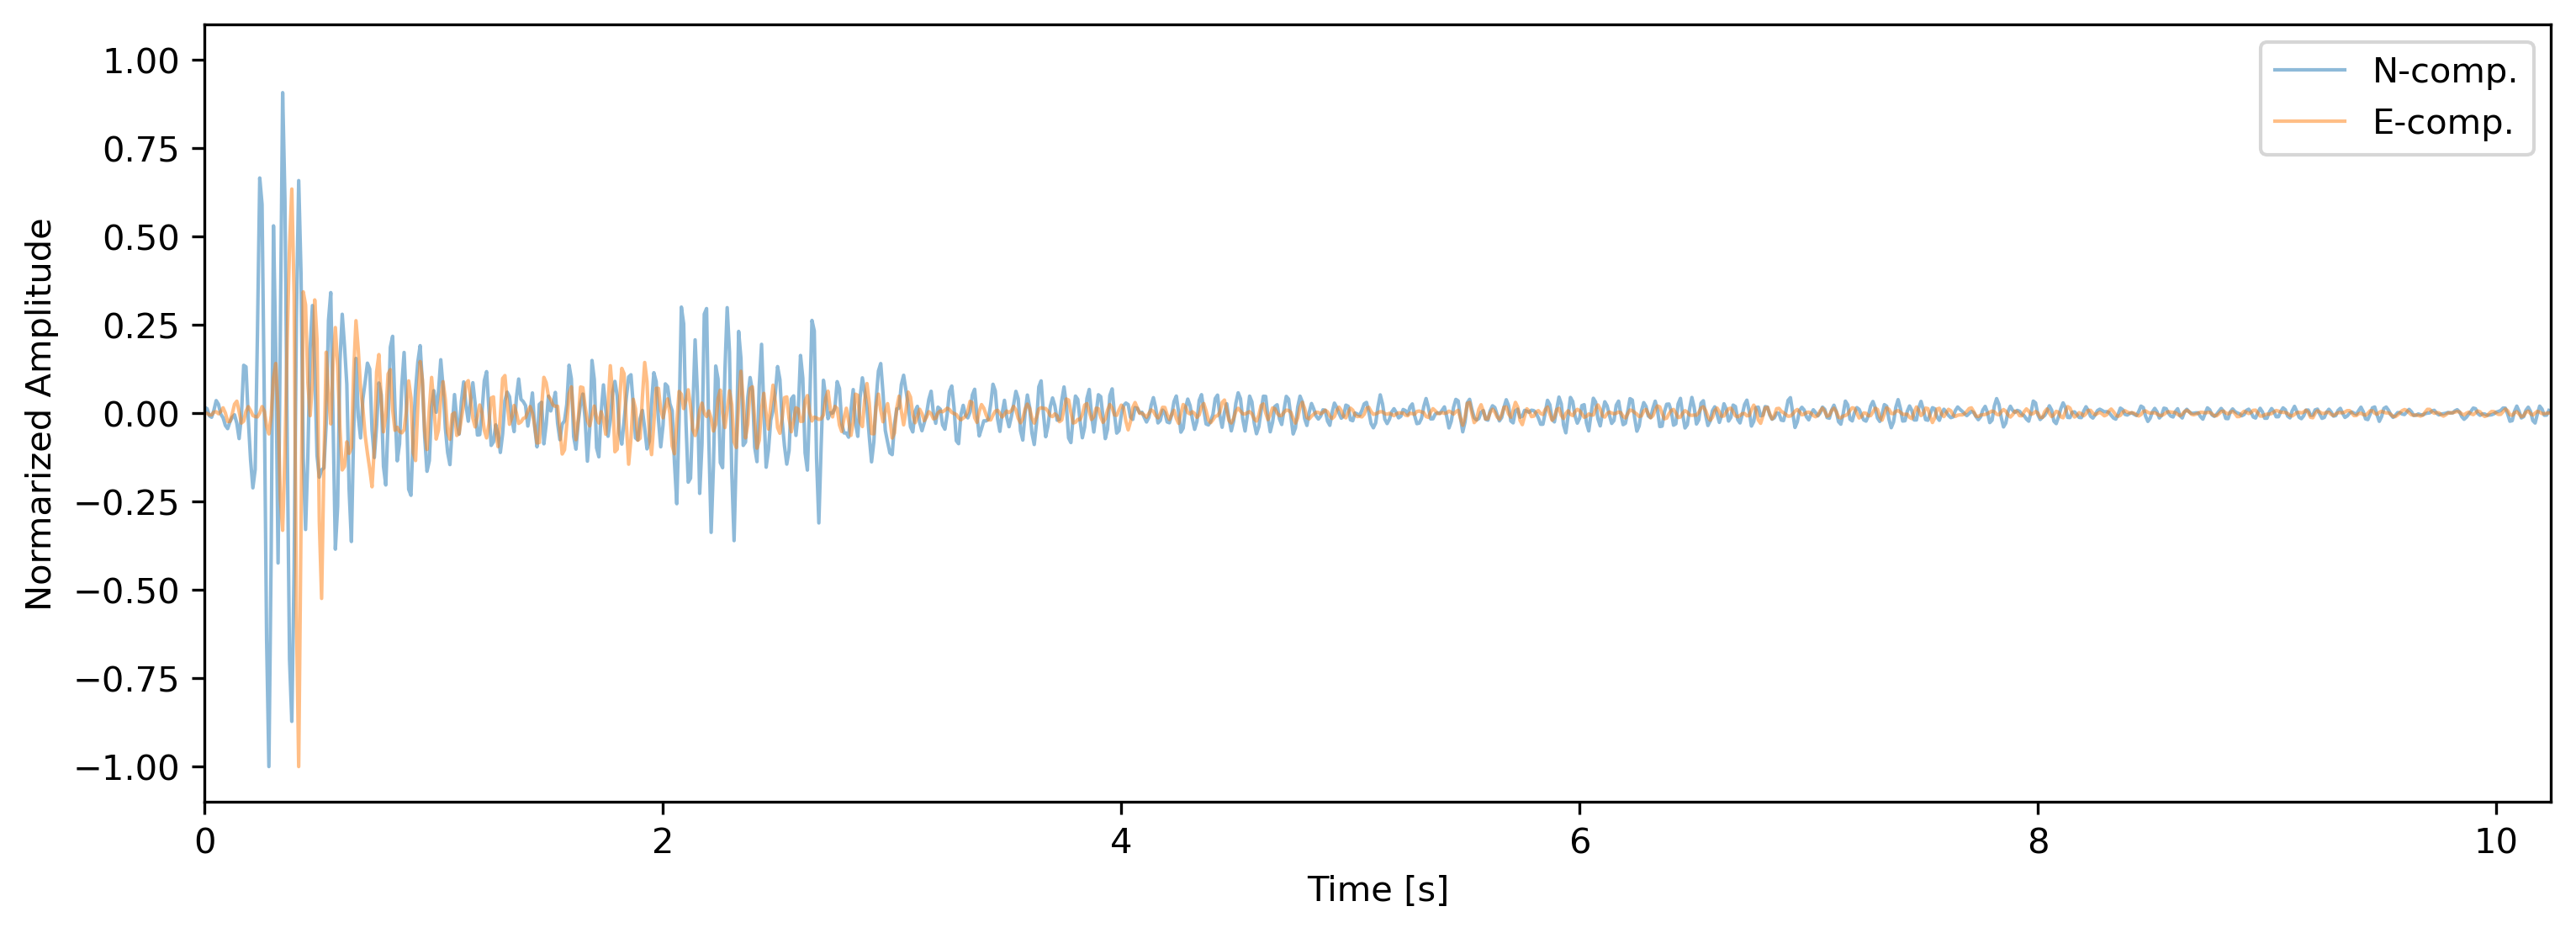

In [10]:
# Check the input data (if you want)
plt.style.use('default')
plt.figure(figsize=(12,4),dpi=300)
plt.plot(np.arange(0,10.24,0.01),s_coda_n[3], linewidth=1, alpha=0.5, label='N-comp.')
plt.plot(np.arange(0,10.24,0.01),s_coda_e[3], linewidth=1, alpha=0.5, label='E-comp.')
plt.legend()
plt.xlim(0,10.24)
plt.ylim(-1.1,1.1)
plt.xlabel('Time [s]')
plt.ylabel('Normarized Amplitude')

In [11]:
# Model (LPS-detector)
nb_features = 1024
nb_components = 2
nb_class = 1
model = Sequential()
filtlen=16
model.add(Convolution1D(filters=8, kernel_size=filtlen, activation='relu', padding='same', input_shape=(nb_features, nb_components)))
model.add(MaxPool1D(2))
model.add(Dropout(0.4))
model.add(Convolution1D(filters=16, kernel_size=filtlen, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Dropout(0.4))
model.add(Convolution1D(filters=32, kernel_size=filtlen, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Dropout(0.4))
model.add(Convolution1D(filters=64, kernel_size=filtlen, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(nb_class, activation='sigmoid'))
adam =Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=[tf.keras.metrics.AUC()])
model.summary()
model.load_weights('./lpsditector_modelweight.h5')

/Users/amezawa/anaconda3/envs/lpsdetector/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/Users/amezawa/anaconda3/envs/lpsdetector/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 1024, 8)        │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 512, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 512, 16)        │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 256, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 256, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 128, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,521 (681.72 KB)

 Trainable params: 174,521 (681.72 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# LPS detection & output the detection results (prediction)
prediction = model.predict([x_pred])
np.savetxt('./lpsdetector_out.txt', prediction, fmt='%11.8f')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
